In [1]:
import gym
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
#parameters

DEVICE=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 0.1
DISCOUNT = 0.95
EPISODES = 25000
SHOW_EVERY = 2000


In [3]:
# init env

env = gym.make("MountainCar-v0")
env.reset()

array([-0.40503746,  0.        ], dtype=float32)

In [4]:
# observation space inf

print(env.observation_space.high)
print(env.observation_space.low)
print(env.action_space.n)

[0.6  0.07]
[-1.2  -0.07]
3


In [5]:
#discrete observation state 

DISCRETE_OS_SIZE = [20] * len(env.observation_space.high)
discrete_os_win_size = (env.observation_space.high - env.observation_space.low) / DISCRETE_OS_SIZE
print(discrete_os_win_size)

[0.09  0.007]


In [6]:
#create Q-table

q_table = np.random.uniform(low=-2, high=0, size=(DISCRETE_OS_SIZE + [env.action_space.n]))
print(q_table.shape)

(20, 20, 3)


In [7]:
# For stats
ep_rewards = []
aggr_ep_rewards = {'ep': [], 'avg': [], 'max': [], 'min': []}

In [8]:
# exploration settings

epsilon = 0.5  	#not a const, decay later
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = EPISODES // 2
epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)


In [9]:
# get discrete state function

def get_discrete_state(state):
	discrete_state = (state - env.observation_space.low) / discrete_os_win_size
	
	# we use this tuple to look up the 3 Q values for the available actions in the q-table
	return tuple(discrete_state.astype(np.int_))

In [10]:
for episode in range(EPISODES):
	discrete_state = get_discrete_state(env.reset())
	done = False

	episode_reward = 0

	if episode % SHOW_EVERY == 0:
		render = True
	else:
		render = False

	while not done:

		if np.random.random() > epsilon:
			# Get action from Q table
			action = np.argmax(q_table[discrete_state])
		else:
			#get rand action
			action = np.random.randint(0, env.action_space.n)
	
		new_state, reward, done, _ = env.step(action)
		episode_reward += reward
		new_discrete_state = get_discrete_state(new_state)

		if render:
			env.render()

		if not done:
			# Update Q table with new Q value
			max_future_q = np.max(q_table[new_discrete_state])
			# Current Q value (for current state and performed action)
			current_q = q_table[discrete_state + (action, )]
			# And here's our equation for a new Q value for current state and action
			new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
			# Update Q table with new Q value - after taken the action
			q_table[discrete_state + (action, )] = new_q

		# Simulation ended (for any reson) - if goal position is achived - update Q value with reward directly	
		elif new_state[0] >= env.goal_position:
			# print(f"We made it on episode {episode}")
			q_table[discrete_state + (action, )] = 0
		
		discrete_state = new_discrete_state

	# Decaying is being done every episode if episode number is within decaying range
	if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
		epsilon -= epsilon_decay_value
	
	ep_rewards.append(episode_reward)

	if not episode % 10:
		np.save(f"qtables/{episode}-qtable.npy", q_table)

	if not episode % SHOW_EVERY:
		average_reward = sum(ep_rewards[-SHOW_EVERY:])/len(ep_rewards[-SHOW_EVERY:])
		aggr_ep_rewards['ep'].append(episode)
		aggr_ep_rewards['avg'].append(average_reward) 
		aggr_ep_rewards['min'].append(min(ep_rewards[-SHOW_EVERY:])) 
		aggr_ep_rewards['max'].append(max(ep_rewards[-SHOW_EVERY:])) 

		print(f'Episode: {episode}, average: {average_reward}, min: {min(ep_rewards[-SHOW_EVERY:])}, max: {max(ep_rewards[-SHOW_EVERY:])}')

env.close()

Episode: 0, average: -200.0, min: -200.0, max: -200.0
Episode: 2000, average: -199.8115, min: -200.0, max: -156.0
Episode: 4000, average: -197.843, min: -200.0, max: -146.0
Episode: 6000, average: -191.7555, min: -200.0, max: -135.0
Episode: 8000, average: -186.6105, min: -200.0, max: -119.0
Episode: 10000, average: -185.395, min: -200.0, max: -126.0
Episode: 12000, average: -167.911, min: -200.0, max: -114.0
Episode: 14000, average: -149.434, min: -200.0, max: -110.0
Episode: 16000, average: -135.424, min: -193.0, max: -110.0
Episode: 18000, average: -129.168, min: -184.0, max: -111.0
Episode: 20000, average: -128.556, min: -150.0, max: -112.0
Episode: 22000, average: -128.3275, min: -150.0, max: -112.0
Episode: 24000, average: -128.8325, min: -149.0, max: -112.0


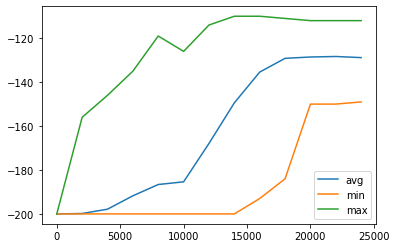

In [11]:
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label='avg')
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label='min')
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label='max')
plt.legend(loc=4)
plt.show()


In [12]:
# if want to save the Q table:

# for episode in range(EPISODES):
#     ...
#     # AT THE END
#     np.save(f"qtables/{episode}-qtable.npy", q_table)

# env.close()

# or
# if episode % 10 == 0:
# 	np.save(f"qtables/{episode}-qtable.npy", q_table)

In [1]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np

style.use('ggplot')


def get_q_color(value, vals):
    if value == max(vals):
        return "green", 1.0
    else:
        return "red", 0.3


fig = plt.figure(figsize=(12, 9))


for i in range(16340, 25000, 10):
    print(i)
    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)

    q_table = np.load(f"qtables/{i}-qtable.npy")
	
    for x, x_vals in enumerate(q_table):
        for y, y_vals in enumerate(x_vals):
            ax1.scatter(x, y, c=get_q_color(y_vals[0], y_vals)[0], marker="o", alpha=get_q_color(y_vals[0], y_vals)[1])
            ax2.scatter(x, y, c=get_q_color(y_vals[1], y_vals)[0], marker="o", alpha=get_q_color(y_vals[1], y_vals)[1])
            ax3.scatter(x, y, c=get_q_color(y_vals[2], y_vals)[0], marker="o", alpha=get_q_color(y_vals[2], y_vals)[1])

            ax1.set_ylabel("Action 0")
            ax2.set_ylabel("Action 1")
            ax3.set_ylabel("Action 2")

    #plt.show()
    plt.savefig(f"qtable_charts/{i}.png")
    plt.clf()

16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
17170
17180
17190
17200
17210
17220
17230
17240
17250
17260
17270
17280
17290
17300
17310
17320
17330
17340
17350
17360
17370
17380
17390
17400
17410
17420
17430
17440
17450
17460
17470
17480
17490
17500
17510
17520
17530
17540
17550
17560
17570
17580
17590
17600
17610
17620
17630
17640
17650
17660
17670
17680
17690
17700
17710
17720
17730
17740
17750
17760
17770
17780
17790
17800
17810
17820
17830
17840
17850
17860
17870
17880
17890
17900
17910
17920
17930
17940
17950
17960
17970
17980
17990
1800

<Figure size 864x648 with 0 Axes>

In [5]:
import cv2

img_path = f"qtable_charts/10.png"
# print(img_path)
frame = cv2.imread(img_path)
print(frame.shape)

(648, 864, 3)


In [ ]:
import cv2
import os


def make_video():
    img_path = f"qtable_charts/10.png"
    img = cv2.imread(img_path)
	# windows:
    # fourcc = cv2.VideoWriter_fourcc(*'XVID')
    fourcc = cv2.VideoWriter_fourcc(*'MP4V') 
    # Linux:
    #fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
    out = cv2.VideoWriter('qlearn.mp4', fourcc, 60.0, (img.shape[1], img.shape[0]))

    for i in range(0, 24000, 10):
        img_path = f"qtable_charts/{i}.png"
        # print(img_path)
        frame = cv2.imread(img_path)
        out.write(frame)

    out.release()


make_video()